# Easter's homework
In this notebook, I report the activities agreed at ML4NP meeting on 8 April 2020.
The activities are the following:
1. Check for **correspondance** between **energy lost** and **energy deposited** in CJ simulations.
1. Analyse what are the **events** that survive at **ROI cut** and what are the events lost.
1. Compare the energy distribution using a **symmetric OP map** to prove the eventual efficiency in changing the fiber placement.
1. Produce some **Ar39 toy simulation** with MC script by Mario Schwarz.

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 18})

## Correspondance of energy lost and deposited

## Impact of ROI cut on simulated events
In the last-meeting presentation (*slide 3*), I reported `10594` events in ROI and only `6670` events detected. We aim to address the following questions:
- What are the event lost in the detection? 
- Why there is only a ~60% efficiency?

First of all, I explain the previous data:
- *events in ROI* := number of events with at least 1 entry in ROI among the 2e6 muon simulated by CJ.
- *events detected* := number of events with at least 1 OP detected using Neil's Map and Yield=40 OP/KeV.

In [3]:
# Reproduce the result of last-meeting presentation
dir_in = os.path.join("..", "Data", "cutROI")
new_file = "output2eROI_all_wt_ops.csv"
columns = ['PID', 'energydeposition', 'x', 'y', 'z', 'eventnumber', 'creatorprocess', 'OPs']



light_yield = 40    # number of photons per KeV
df = pd.read_csv(os.path.join(dir_in, new_file), index_col=False)[columns]
df = df[df.energydeposition>0]

# Add fields to filter detected events and see energy detected
df["OPdetected"] = df.energydeposition * light_yield * df.OPs  # OP Detected = Edep * LYield * DetEff
df["energydetected"] = df.OPdetected / light_yield             # Energy Detected = OP Detected / LYield
df["dist_origin"] = (df.x**2 + df.y**2 + df.z**2)**.5          # Euclidean distance from origin

print("[Info] Number of distinct events: {}".format(df.eventnumber.nunique()))
print("[Info] Number of detected events: {}".format(df[df.OPdetected>0].eventnumber.nunique()))

# Preview of data loaded
df.head()

[Info] Number of distinct events: 10594
[Info] Number of detected events: 6670


,PID,energydeposition,x,y,z,eventnumber,creatorprocess,OPs,OPdetected,energydetected,dist_origin
2,22,3.20630,410.980,174.100,-946.000,210,eBrem,0.0,0.0,0.0,1046.007347
3,11,168.22100,411.045,174.073,-946.066,210,phot,0.0,0.0,0.0,1046.088083
4,11,3.54527,468.747,244.047,-915.800,210,compt,0.0,0.0,0.0,1057.342106
5,11,8.27316,491.863,275.561,-885.021,210,compt,0.0,0.0,0.0,1049.345151
7,11,179.84300,211.392,-220.104,-960.597,466,compt,0.0,0.0,0.0,1007.908203


[Info] Selected entries of lost events: 203805


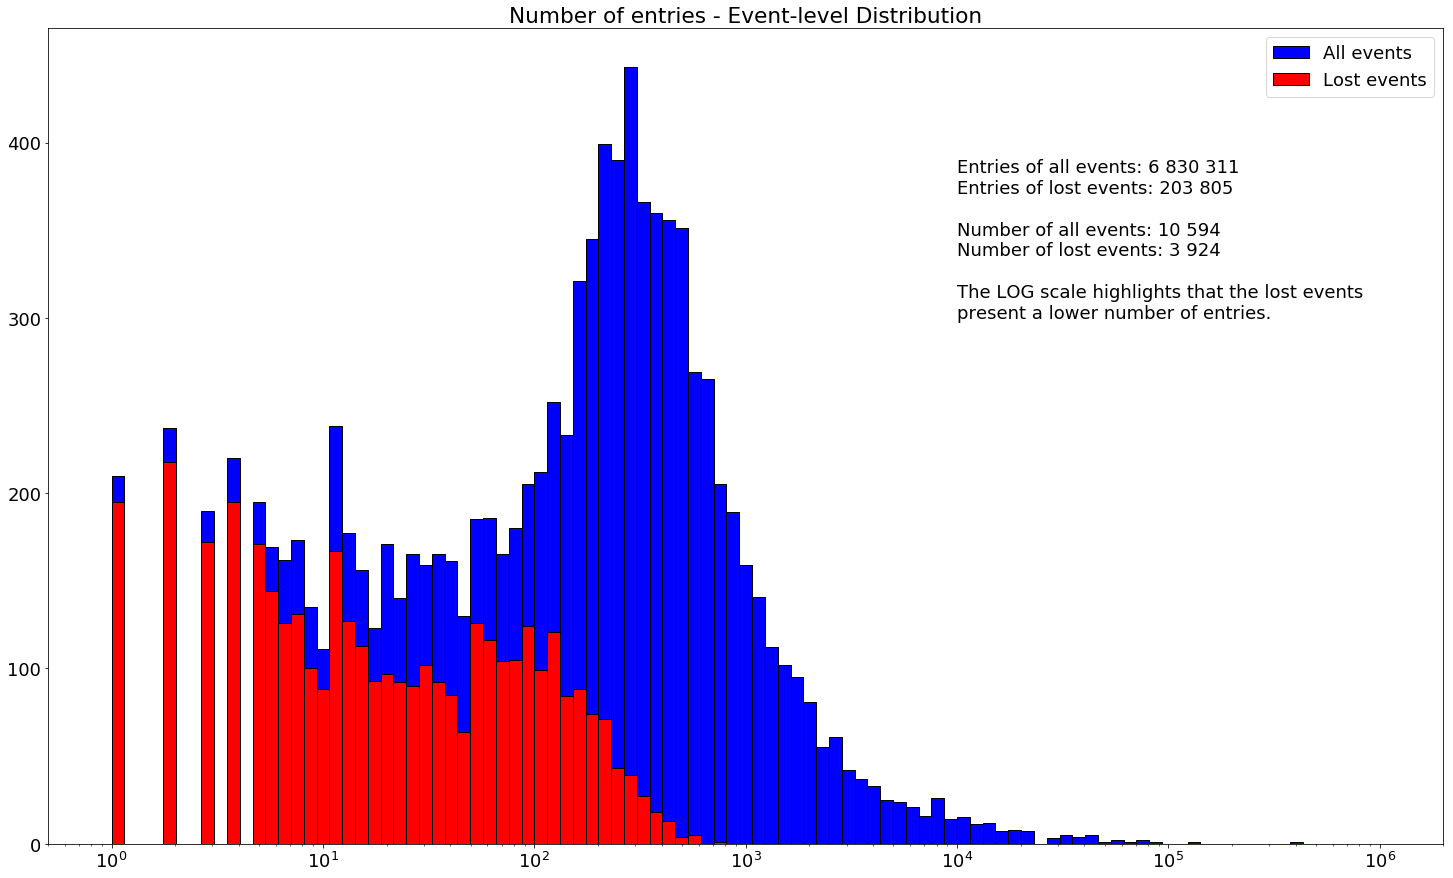

In [4]:
# Analyse lost events
detectedevents_ids = df[df.OPdetected>0].eventnumber.unique()
df_lostevents = df[~(df.eventnumber.isin(detectedevents_ids))]
print("[Info] Selected entries of lost events: {}".format(len(df_lostevents)))

# Distribution of number of entries in lost events
logbins = np.logspace(0, 6, 100)    # Since there are lost events with very high number of entries
lostevents_nentries = df_lostevents.groupby("eventnumber").PID.count()
plt.hist(df.groupby("eventnumber").PID.count(), bins=logbins, color='b', edgecolor='k', label="All events")
plt.hist(lostevents_nentries, bins=logbins, color='r', edgecolor='k', label="Lost events")
plt.title("Number of entries - Event-level Distribution")
plt.xscale('log')
plt.text(10000, 300, "Entries of all events: 6 830 311\n" \
                     "Entries of lost events: 203 805\n\n" \
                     "Number of all events: 10 594\n" \
                     "Number of lost events: 3 924\n\n" \
                     "The LOG scale highlights that the lost events\n" \
                     "present a lower number of entries.")
plt.legend()
plt.show()

In [ ]:
# Analyse lost events w.r.t. coordinates
numbins = 100
lost_distance_stat = df_lostevents.dist_origin.describe()

plt.hist(df.dist_origin, bins=numbins, color='b', edgecolor='k', label="All entries")
plt.hist(df_lostevents.dist_origin, bins=numbins, color='r', edgecolor='k', label="Lost entries")
plt.title("Distance from origin - Step-level distribution")
plt.text(-25, 100000, "This plot seems unbalanced compared with the previous\n" \
                    "because the previous shows event-level distribution,\n" \
                    "whilst this one is step-level distribution")

plt.text(-25, 40000, "The entries of lost event\n"  \
                     "are farther from the origin.\n\n" \
                     "Mean: {:.0f}mm, Std: {:.0f}".format(lost_distance_stat.loc["mean"], lost_distance_stat.loc["std"]))
plt.show()

In [ ]:
# Partition the data w.r.t. Z axis (entries with x in [-800, +800] and others)
z_partition1 = df_lostevents[(df_lostevents.z >= -800) & (df_lostevents.z <= +800)]
z_partition2 = df_lostevents[(df_lostevents.z < -800) | (df_lostevents.z > +800)]

plt.subplot(2, 1, 1)
plt.scatter(z_partition2.x, z_partition2.y, color='g', label="Part. |Z|>800")
plt.scatter(z_partition1.x, z_partition1.y, color='r', label="Part. |Z|<=800")
plt.title("Lost Energy depositions - X,Y Axis")
plt.legend()

plt.subplot(2, 1, 2)
plt.scatter(z_partition1.x, z_partition1.z, color='r', label="Part. |Z|<=800")
plt.scatter(z_partition2.x, z_partition2.z, color='g', label="Part. |Z|>800")
plt.title("Lost Energy depositions - X,Z Axis")
plt.legend()
plt.show()

### Results:
From the two previous plots, we remark 3 observations:
1. The **ratio of detected events and detected entries is strongly unbalanced**. In particular, we have  ~4k lost events with 200k entries, over ~11k events in ROI with 6M entries. The detection rate is 37% w.r.t. number of events and 3% w.r.t. number of entries. This means that there are **a lot of lost events** to which corresponde a **small part of of entries**.
1. The previous claim is confirmed by the **first plot**, where we highlight that the lost events present a **lower number of entries**. They are then marginal.
1. This marginality is confirmed also with respect to coordinate: the lost events are **far from the origin**, as illustrated in the **second** and **third plot**.